## <center>Extra Work</center>

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

In [4]:
start_date = '2020-01-01'
end_date = '2023-05-12'

ap = yf.download("AAPL", start_date , end_date)['Close']

[*********************100%%**********************]  1 of 1 completed


In [5]:
ap = pd.DataFrame(ap)
ap[ap.isna().any(axis=1)]

,Close
Date,


In [6]:
# First-order differencing
ap_diff = ap.diff().dropna()
# Log price of AP
ap_lgp = np.log(ap)
# Log Returns of AP
ap_rtn = np.log(ap).diff().dropna()

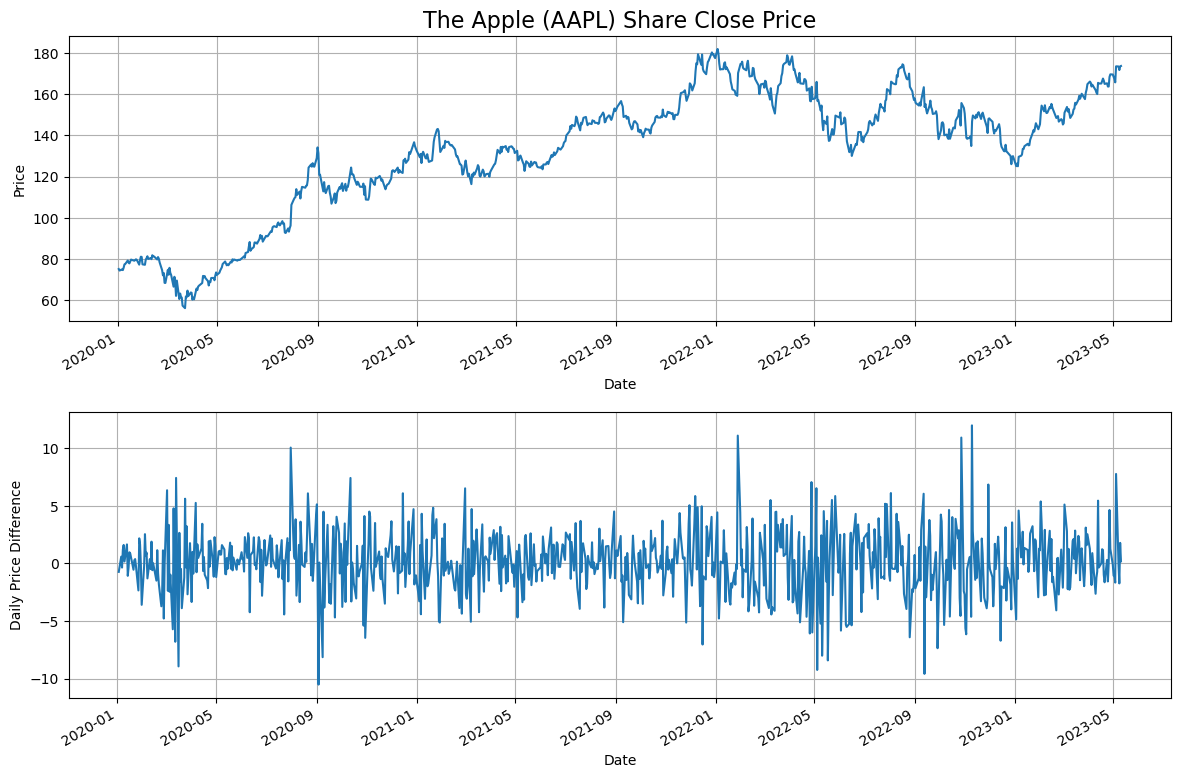

In [7]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
ap['Close'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("The Apple (AAPL) Share Close Price", fontsize = 16)
plt.subplot(2, 1, 2)
ap_diff['Close'].plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Price Difference")

plt.savefig("new_images/Apple_(AAPL)_stationary_1")

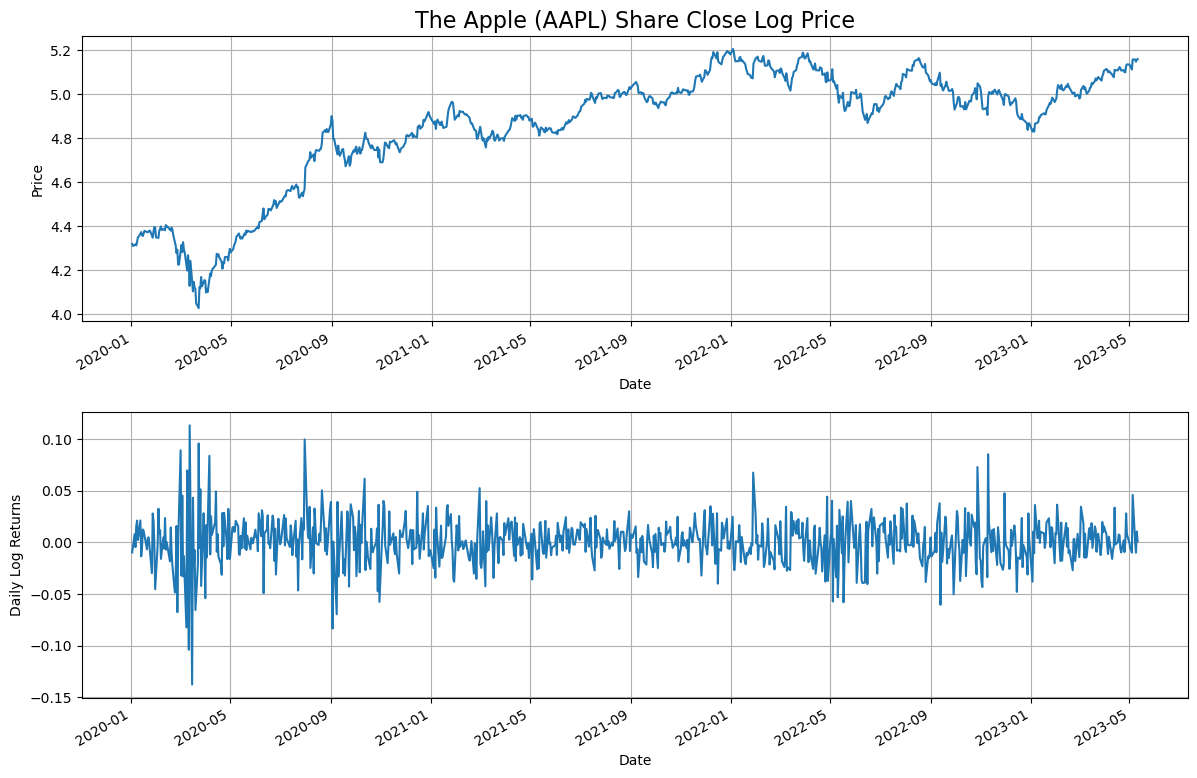

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
ap_lgp['Close'].plot()
plt.grid()
plt.ylabel("Price")
plt.title("The Apple (AAPL) Share Close Log Price", fontsize = 16)
plt.subplot(2, 1, 2)
ap_rtn['Close'].plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Log Returns")

plt.savefig("new_images/Apple_(AAPL)_stationary_2")

### ARIMA

In [9]:
# Get the number of rows to train the model on
training_ap_len = int(np.ceil(len(ap) * .8 ))
# Create the scaled training data set
train_ap = ap[0:int(training_ap_len)]
# First-order differencing
train_ap_diff = train_ap.diff().dropna()
# Log price 
train_ap_lgp = np.log(train_ap)
# Log Returns 
train_ap_rtn = np.log(train_ap).diff().dropna()

In [10]:
# Pirce d=0
result = adfuller(train_ap)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.578562
p-value: 0.494353
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [11]:
# Pirce d=1
result = adfuller(train_ap_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.641732
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [12]:
# Log Pirce d=0
result = adfuller(train_ap_lgp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.574681
p-value: 0.496298
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [13]:
# Log Pirce d=1
result = adfuller(train_ap_rtn)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.258065
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [14]:
def plot_ACF_PACF(data, lag_num, company_name):
    fig, axes = plt.subplots(1,2,figsize=(15,5))

    fig = plot_acf(data.values, lags = lag_num, zero=False, ax = axes[0],
                   title= 'ACF of ' + company_name + ' log prices')
    
    fig = plot_pacf(data.values, lags = lag_num, zero=False, ax = axes[1],
                   title= 'PACF of ' + company_name + ' log prices')

    # plt.show()
    plt.savefig("new_images/ACF PACF" + company_name, dpi = 300)

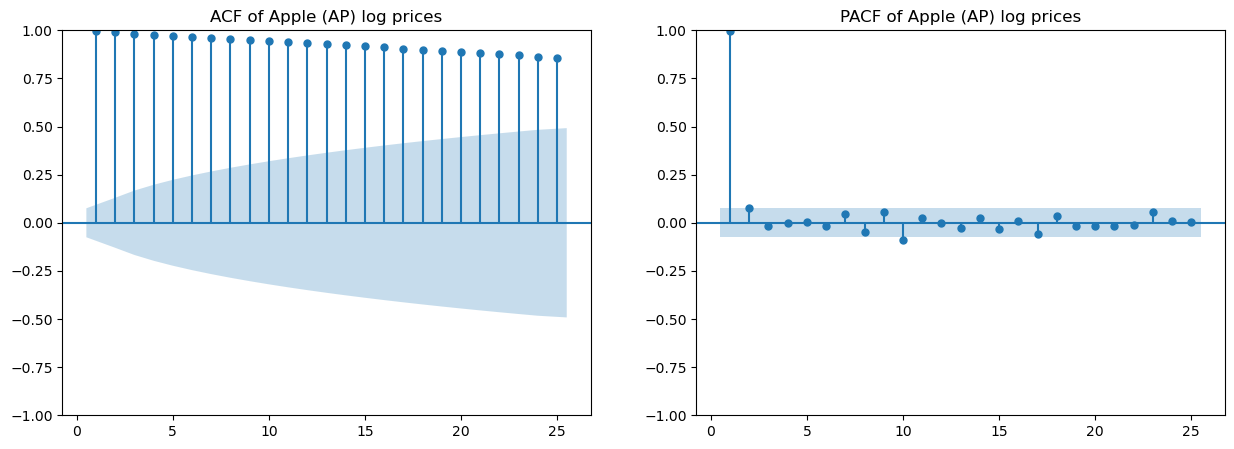

In [15]:
plot_ACF_PACF(train_ap_lgp, 25, 'Apple (AP)')

In [16]:
def searchARIMA(data, d, max_p, max_q):
    results = []

    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))

    for i in range(max_p):
        for j in range(max_q):
            model = ARIMA(data, order=(i, d, j))
            model = ARIMA(data, order=(i, d, j))
            res = model.fit()
            aic[i, j] = res.aic
            bic[i, j] = res.bic

            result_dict = {
                'p': i,
                'q': j,
                'aic': aic[i, j],
                'bic': bic[i, j]
            }
            results.append(result_dict)
            # print('p:', i, ' q:', j, ' aic:', aic[i, j], ' bic:', bic[i, j])

    result_df = pd.DataFrame(results)
    return result_df

In [17]:
result_df = searchARIMA(train_ap_lgp.values, d = 1, max_p = 10, max_q = 10)
result_df

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

,p,q,aic,bic
0,0,0,-3179.664473,-3175.148280
1,0,1,-3194.204657,-3185.172271
2,0,2,-3194.055748,-3180.507169
3,0,3,-3192.262784,-3174.198012
4,0,4,-3190.888137,-3168.307171
...,...,...,...,...
95,9,5,-3203.345669,-3135.602773
96,9,6,-3201.034374,-3128.775284
97,9,7,-3197.136715,-3120.361433
98,9,8,-3199.820345,-3118.528870


In [18]:
min_aic_bic_row = result_df[(result_df['aic'] == result_df['aic'].min()) |
                            (result_df['bic'] == result_df['bic'].min())]
min_aic_bic_row

,p,q,aic,bic
10,1,0,-3195.652373,-3186.619987
25,2,5,-3214.931029,-3178.801485


In [19]:
p, d, q = 1, 1, 0
ar_model_ap = ARIMA(train_ap_lgp['Close'], order=(p, d, q))
ar_model_ap = ar_model_ap.fit()
ar_model_ap.summary()

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  677
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1599.826
Date:                Fri, 15 Dec 2023   AIC                          -3195.652
Time:                        21:53:47   BIC                          -3186.620
Sample:                             0   HQIC                         -3192.155
                                - 677                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1622      0.025     -6.602      0.000      -0.210      -0.114
sigma2         0.0005   1.74e-05     29.622      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               411.05
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Set the significance level (alpha)
alpha = 0.05

p_values = ar_model_ap.pvalues

significant_predictors = p_values[p_values <= alpha]

print("Significant Predictors:")
print(significant_predictors)

Significant Predictors:
ar.L1      4.042952e-11
sigma2    7.791997e-193
dtype: float64


In [21]:
predicted_original_train_ap = ar_model_ap.predict(start=train_ap_lgp.index[0], 
                                                  end=train_ap_lgp.index[-1], 
                                                  dynamic=False)
predicted_original_train_ap = np.exp(predicted_original_train_ap)

In [22]:
predicted_original_train_ap = pd.DataFrame(predicted_original_train_ap)

train_val_ap = ap[:int(training_ap_len)]
train_val_ap = pd.merge(train_val_ap, predicted_original_train_ap, 
                        left_index=True, right_index=True)
train_val_ap = train_val_ap.rename(columns={'predicted_mean': 'Prediction'})
train_val_ap

,Close,Prediction
Date,,
2020-01-02,75.087502,1.000000
2020-01-03,74.357498,75.087501
2020-01-06,74.949997,74.475393
2020-01-07,74.597504,74.853596
2020-01-08,75.797501,74.654552
...,...,...
2022-09-01,157.960007,157.492830
2022-09-02,155.809998,157.839770
2022-09-06,154.529999,156.156649


In [23]:
train_mse = mean_squared_error(train_val_ap['Close'], train_val_ap['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 15.267239201819622
The RMSE of the Trainning set is 3.907331468127528


In [24]:
# Create the scaled training data set
test_ap = ap[int(training_ap_len):]
# Log price
test_ap_lgp = np.log(test_ap)

forecast_ap = ar_model_ap.get_forecast(steps=len(test_ap_lgp))

predicted_values_ap = forecast_ap.predicted_mean
predicted_original_ap = np.exp(predicted_values_ap)
predicted_original_ap = np.array(predicted_original_ap)

C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\surface\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
predicted_original_ap = pd.DataFrame(index=test_ap_lgp.index, columns=['Prediction'], 
                                     data=predicted_original_ap)

test_ap = pd.merge(test_ap, predicted_original_ap, 
                   left_index=True, right_index=True)
test_ap

,Close,Prediction
Date,,
2022-09-09,157.369995,154.702266
2022-09-12,163.429993,154.662955
2022-09-13,153.839996,154.669329
2022-09-14,155.309998,154.668296
2022-09-15,152.369995,154.668463
...,...,...
2023-05-05,173.570007,154.668440
2023-05-08,173.500000,154.668440
2023-05-09,171.770004,154.668440


In [26]:
test_mse = mean_squared_error(test_ap['Close'], test_ap['Prediction'])
test_rmse = np.sqrt(test_mse)
print("The MSE of the Test set is", test_mse)
print("The RMSE of the Test set is", test_rmse)

The MSE of the Test set is 151.67952046747203
The RMSE of the Test set is 12.315823986541544


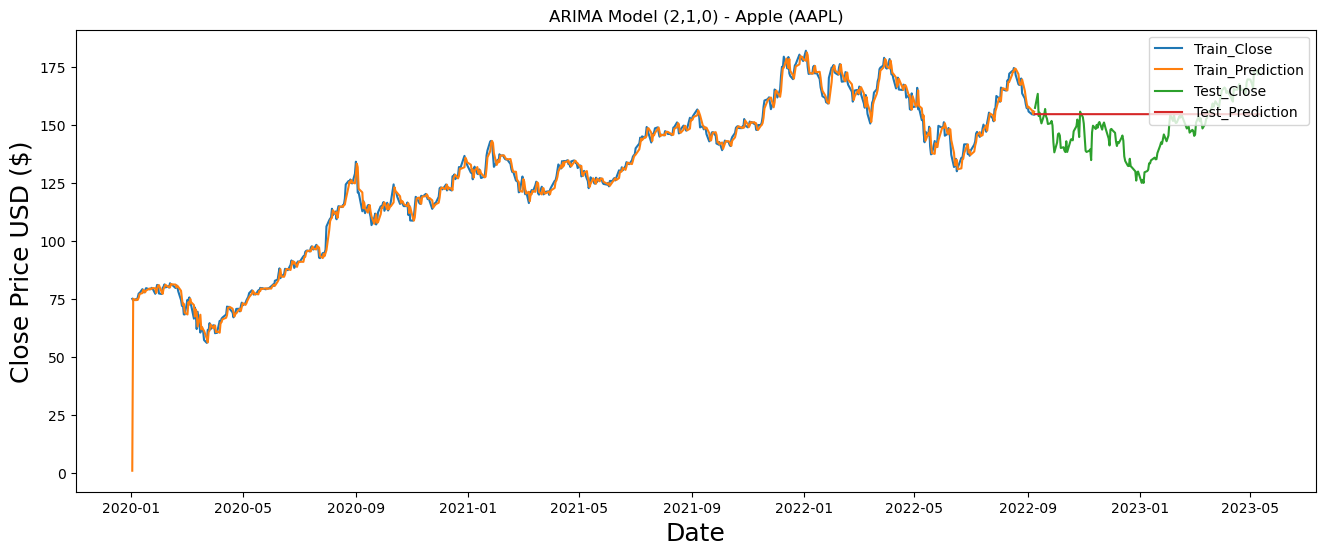

In [27]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('ARIMA Model (2,1,0) - Apple (AAPL)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ap[['Close', 'Prediction']])
plt.plot(test_ap[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("new_images/Apple_(AAPL)_ARIMA_1")

### LSTM

In [28]:
scaler_ap = MinMaxScaler(feature_range=(0,1))
scaled_ap = scaler_ap.fit_transform(ap)

In [29]:
# Get the number of rows to train the model on
training_ap_len = int(np.ceil( len(scaled_ap) * .8 ))
training_ap_len

677

In [30]:
# Create the scaled training data set
train_ap = scaled_ap[0:int(training_ap_len), :]

In [31]:
def Split_train_data_with_lookback_window(train_data, timestamps):
    x_train = []
    y_train = []
    
    for i in range(timestamps, len(train_data)):
        x_train.append(train_data[i-10:i, 0])
        y_train.append(train_data[i, 0])
        if i<= timestamps+1:
            print(x_train)
            print(y_train)
            print()
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train

In [32]:
x_train_ap, y_train_ap = Split_train_data_with_lookback_window(train_ap, 10)

[array([0.15085277, 0.14505529, 0.14976075, 0.14696135, 0.15649137,
       0.16927753, 0.17066729, 0.18383068, 0.17533306, 0.17267259])]
[0.18041574483384826]

[array([0.15085277, 0.14505529, 0.14976075, 0.14696135, 0.15649137,
       0.16927753, 0.17066729, 0.18383068, 0.17533306, 0.17267259]), array([0.14505529, 0.14976075, 0.14696135, 0.15649137, 0.16927753,
       0.17066729, 0.18383068, 0.17533306, 0.17267259, 0.18041574])]
[0.18041574483384826, 0.18734492638202815]



In [33]:
# Build the LSTM model
lstm_model_ap = Sequential()
lstm_model_ap.add(LSTM(4, input_shape= (x_train_ap.shape[1], 1)))
lstm_model_ap.add(Dense(1))
# Compile the model
lstm_model_ap.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = lstm_model_ap.fit(x_train_ap, y_train_ap, batch_size=256, epochs=100, verbose=2)

Epoch 1/100
3/3 - 5s - loss: 0.8889 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.8540 - 23ms/epoch - 8ms/step
Epoch 3/100
3/3 - 0s - loss: 0.8206 - 21ms/epoch - 7ms/step
Epoch 4/100
3/3 - 0s - loss: 0.7889 - 22ms/epoch - 7ms/step
Epoch 5/100
3/3 - 0s - loss: 0.7586 - 23ms/epoch - 8ms/step
Epoch 6/100
3/3 - 0s - loss: 0.7297 - 25ms/epoch - 8ms/step
Epoch 7/100
3/3 - 0s - loss: 0.7019 - 23ms/epoch - 8ms/step
Epoch 8/100
3/3 - 0s - loss: 0.6758 - 34ms/epoch - 11ms/step
Epoch 9/100
3/3 - 0s - loss: 0.6510 - 24ms/epoch - 8ms/step
Epoch 10/100
3/3 - 0s - loss: 0.6271 - 22ms/epoch - 7ms/step
Epoch 11/100
3/3 - 0s - loss: 0.6045 - 22ms/epoch - 7ms/step
Epoch 12/100
3/3 - 0s - loss: 0.5824 - 23ms/epoch - 8ms/step
Epoch 13/100
3/3 - 0s - loss: 0.5618 - 22ms/epoch - 7ms/step
Epoch 14/100
3/3 - 0s - loss: 0.5418 - 23ms/epoch - 8ms/step
Epoch 15/100
3/3 - 0s - loss: 0.5231 - 22ms/epoch - 7ms/step
Epoch 16/100
3/3 - 0s - loss: 0.5045 - 22ms/epoch - 7ms/step
Epoch 17/100
3/3 - 0s - loss: 0.486

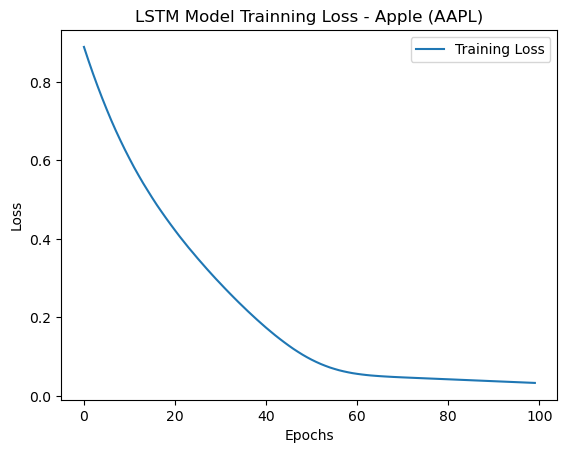

In [34]:
# Plot the training loss - Convergence
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Trainning Loss - Apple (AAPL)')
plt.legend()
#plt.show()
plt.savefig("new_images/LSTM Model Trainning Loss - Apple (AAPL)")

In [35]:
y_train_ap = ap[10:training_ap_len].values
# Get the models predicted price values 
train_pred_ap = lstm_model_ap.predict(x_train_ap)
train_pred_ap = scaler_ap.inverse_transform(train_pred_ap)

train_val_ap = ap[10:training_ap_len]
train_val_ap['Prediction'] = train_pred_ap
train_val_ap

21/21 [==============================] - 1s 3ms/step


C:\Users\surface\AppData\Local\Temp\ipykernel_10576\1390658575.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val_ap['Prediction'] = train_pred_ap


,Close,Prediction
Date,,
2020-01-16,78.809998,116.177139
2020-01-17,79.682503,116.301277
2020-01-21,79.142502,116.443954
2020-01-22,79.425003,116.620178
2020-01-23,79.807503,116.781670
...,...,...
2022-09-01,157.960007,141.753510
2022-09-02,155.809998,141.211136
2022-09-06,154.529999,140.900467


In [36]:
train_mse = mean_squared_error(train_val_ap['Close'], train_val_ap['Prediction'])
train_rmse = np.sqrt(train_mse)
print("The MSE of the Trainning set is", train_mse)
print("The RMSE of the Trainning set is", train_rmse)

The MSE of the Trainning set is 522.5024792895756
The RMSE of the Trainning set is 22.85831313307208


In [37]:
# get test data set and split into X and y
def Split_test_data_with_lookback_window(scaled_data, original_data, training_data_len, timestamps):
    # Create the testing data set
    test_data = scaled_data[training_data_len - 10: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = original_data[training_data_len:].values
    
    for i in range(timestamps, len(test_data)):
        x_test.append(test_data[i-timestamps:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    
    return x_test, y_test

In [38]:
x_test_ap, y_test_ap = Split_test_data_with_lookback_window(scaled_ap, ap, training_ap_len, 10)

In [39]:
# Get the models predicted price values 
pred_ap = lstm_model_ap.predict(x_test_ap)
pred_ap = scaler_ap.inverse_transform(pred_ap)

test_ap = ap[training_ap_len:]
test_ap['Prediction'] = pred_ap

# Get MSE and RMSE
test_mse_ap = np.mean(((pred_ap - y_test_ap) ** 2))
test_rmse_ap = np.sqrt(test_mse_ap)
print("The MSE of the Test set is", test_mse_ap)
print("The RMSE of the Test set is", test_rmse_ap)

6/6 [==============================] - 0s 2ms/step
The MSE of the Test set is 234.2003464356844
The RMSE of the Test set is 15.303605667805362


C:\Users\surface\AppData\Local\Temp\ipykernel_10576\2423058360.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ap['Prediction'] = pred_ap


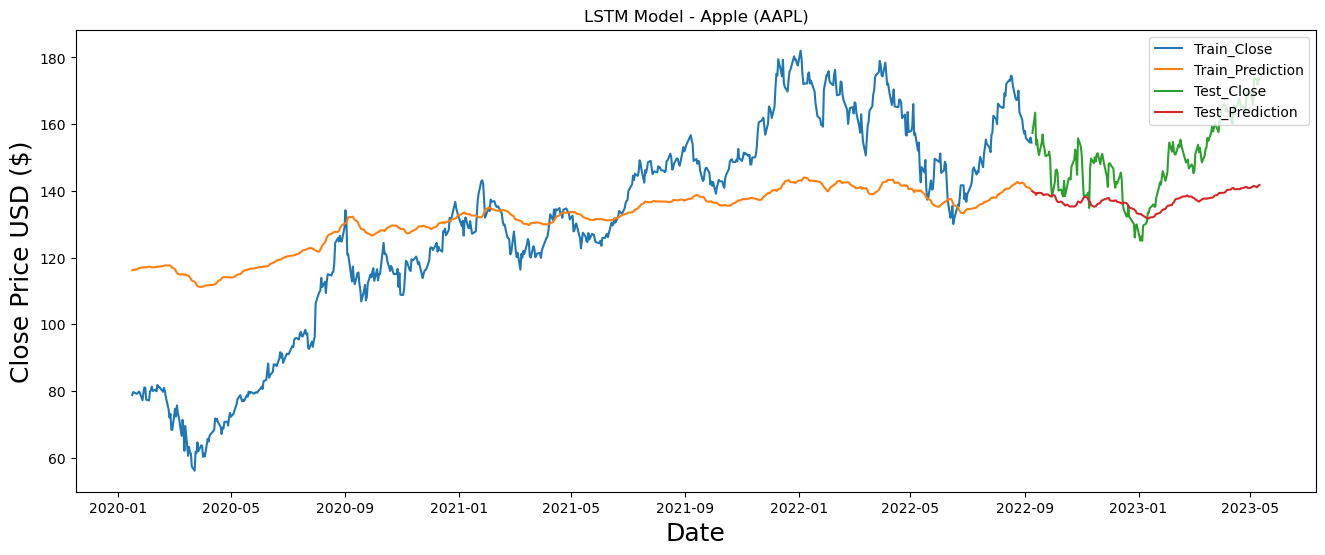

In [40]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model - Apple (AAPL)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_val_ap[['Close', 'Prediction']])
plt.plot(test_ap[['Close', 'Prediction']])
plt.legend(['Train_Close', 'Train_Prediction','Test_Close', 'Test_Prediction'], loc='upper right')
#plt.show()
plt.savefig("new_images/LSTM Model - Apple (AAPL)") 